In [50]:
# Import library
import cv2
import os
import copy
import sys
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as pt
from sklearn import preprocessing
from keras.applications import resnet
from keras.preprocessing.image import ImageDataGenerator

In [51]:
!unrar x "/content/drive/MyDrive/Covid19-dataset" "/content"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/Covid19-dataset.rar


Would you like to replace the existing file /content/Covid19-dataset/test/Covid/0100.jpeg
163299 bytes, modified on 2020-04-29 08:55
with a new one
163299 bytes, modified on 2020-04-29 08:55

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 
User break

User break


In [ ]:
def read_images(path):    
    paths = list()
    labels=list()
    images_data = list()
    classlabel = os.walk(path).__next__()[1]
    for cls in classlabel:
        c_dir = os.path.join(path,cls)
        images = os.walk(c_dir).__next__()[2]
        for img in images:
            paths.append(os.path.join(c_dir,img))
            labels.append(cls)
    for p in paths:
        # resize image size
        try:
            fix_size_image = cv2.resize(cv2.imread(p),(224,224))
            # normalize image (0,1)
            fix_normalized_image = cv2.normalize(fix_size_image , None, alpha=0, beta=1,
                                 norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        except Exception as e:
            print(e)
        # append to list
        images_data.append(fix_normalized_image)
    return images_data,labels

In [53]:
train,train_labels= read_images('/content/Covid19-dataset/train')
train = np.reshape(train,(len(train),224,224,3))
test,test_labels= read_images('/content/Covid19-dataset/test')
test = np.reshape(test,(len(test),224,224,3))

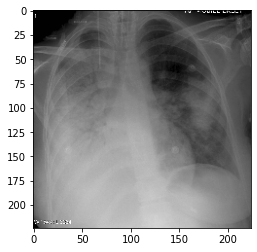

In [94]:
pt.imshow(train[100])

In [55]:
def OneHotCoding(labels):
  le = preprocessing.LabelEncoder()
  le.fit(['Covid','Normal','Viral Pneumonia'])
  y=le.transform(labels)
  oen=preprocessing.OneHotEncoder(sparse=False)
  y = y.reshape(len(y),1)
  y=oen.fit_transform(y)
  y=pd.DataFrame(y)
  labels = np.array(y)
  return labels

In [56]:
# train data one-hot encoding
train_labels=OneHotCoding(train_labels)
# test data one-hot encoding
test_labels=OneHotCoding(test_labels)

In [57]:
resn=resnet.ResNet50(weights='imagenet',include_top = False,input_shape=(224,224,3))
resn.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [77]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(train,train_labels,batch_size=32)
validation_generator = test_datagen.flow(test,test_labels,batch_size=32)

In [78]:
output = resn.layers[-1].output
resn = keras.Model(resn.input, output)
for layer in resn.layers:
    layer.trainable = False
resn.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [83]:
model = keras.Sequential()
model.add(resn)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(3,activation='softmax'))
opt = keras.optimizers.Adam(lr = 0.001)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])
history=model.fit_generator(train_generator,epochs=200,validation_data=validation_generator)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_14 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_32 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 100352)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 3)                 301059    
Total params: 23,888,771
Trainable params: 301,059
Non-trainable params: 23,587,712
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
8/8 [==============================] - 6s 507ms/step - loss: 7.6056 - acc: 0.4473 - val_loss: 8.7749 - val_acc: 0.3788
Epoch 2/200
8/8 [==============================] - 3s 365ms/step - loss: 4.8643 - acc: 0.6353 - val_loss: 2.1363 - val_acc: 0.7424
Epoch 3/200
8/8 [==============================] - 3s 375ms/step - loss: 3.7066 - acc: 0.7125 - val_loss: 1.0081 - val_acc: 0.7879
Epoch 4/200
8/8 [==============================] - 3s 373ms/step - loss: 2.6594 - acc: 0.7979 - val_loss: 6.3019 - val_acc: 0.6515
Epoch 5/200
8/8 [==============================] - 3s 367ms/step - loss: 2.4732 - acc: 0.7679 - val_loss: 1.2191 - val_acc: 0.8030
Epoch 6/200
8/8 [==============================] - 3s 367ms/step - loss: 1.7036 - acc: 0.7672 - val_loss: 1.3801 - val_acc: 0.7727
Epoch 7/200
8/8 [==============================] - 3s 365ms/step - loss: 1.2499 - acc: 0.8444 - val_loss: 1.1205 - val_acc: 0.8030
Epoch 8/200
8/8 [==============================] - 3s 362ms/step - loss: 1.8542 - a

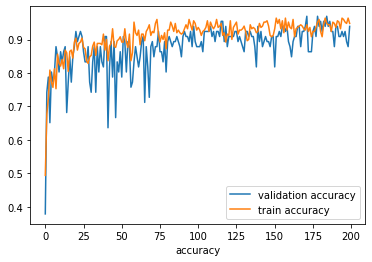

In [93]:
pt.plot(history.history['val_acc'],label = 'validation accuracy')
pt.plot(history.history['acc'],label = 'train accuracy')
pt.xlabel('epochs')
pt.xlabel('accuracy')
pt.legend()
pt.show()

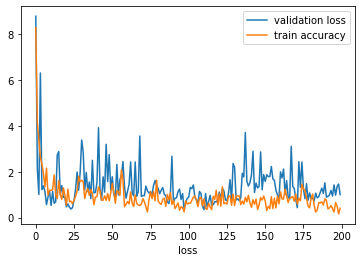

In [96]:
pt.plot(history.history['val_loss'],label = 'validation loss')
pt.plot(history.history['loss'],label = 'train accuracy')
pt.xlabel('epochs')
pt.xlabel('loss')
pt.legend()
pt.show()

In [95]:
model.evaluate(validation_generator)

3/3 [==============================] - 0s 75ms/step - loss: 1.0009 - acc: 0.9394


[1.000886082649231, 0.939393937587738]